In [ ]:
# Imports & Data Preparation
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge


#  Read data
# --------------------------------------------
df = pd.read_csv("C:\\Users\\rosas\\OneDrive\\Desktop\\SML\\Project\\US_Accidents_Featured_Engineered.csv")

#  Define label
# --------------------------------------------
target_cols = ['Severity_count', 'Severity_mean', 'Severity_max']

# Define columns to drop
# --------------------------------------------
drop_from_features = {"grid_id"}

# Drop safely
# --------------------------------------------
existing = [col for col in drop_from_features if col in df.columns]
missing = [col for col in drop_from_features if col not in df.columns]

X = df.drop(columns=existing + target_cols)
y = df[target_cols]
print("After deleting", X.shape)

# Combine → Shuffle → Split
# --------------------------------------------
df_shuffled = shuffle(pd.concat([X, y], axis=1), random_state=42).reset_index(drop=True)
X = df_shuffled.drop(columns=target_cols)
y = df_shuffled[target_cols]


After deleting (11167, 158)


In [ ]:
def manual_regression_kfold_split(X, y, k=5, seed=42, bins=10):
    """
    Perform manual k-fold splitting for regression tasks with stratification.

    This function divides the target variable `y` into quantile-based bins 
    to approximate stratified k-fold cross-validation for regression problems.
    Each fold maintains a similar distribution of target values, ensuring 
    balanced data splits across folds.

    Parameters
    ----------
    X : pd.DataFrame or np.ndarray
        Feature matrix (not directly used for splitting but ensures consistent length).
    y : pd.Series or np.ndarray
        Continuous target variable for regression.
    k : int, default=5
        Number of folds to create.
    seed : int, default=42
        Random seed for reproducibility.
    bins : int, default=10
        Number of quantile bins to discretize `y` for stratification.

    Returns
    -------
    splits : list of tuples
        A list containing `k` (train_indices, test_indices) tuples.
        Each tuple represents one fold's train/test split.
    """

    # Set random seed to ensure reproducible results
    np.random.seed(seed)

    # Discretize continuous target into quantile-based bins
    # This mimics stratification by ensuring each fold has similar y distribution
    y_bins = pd.qcut(y, q=bins, duplicates='drop')

    # Initialize an empty list for k folds
    folds = [[] for _ in range(k)]

    # Reset the index to ensure consistent indexing
    y_binned = y_bins.reset_index(drop=True)

    # Distribute samples from each bin equally across all folds
    for cls in y_binned.unique():
        # Get indices of samples in this bin
        cls_idx = np.where(y_binned == cls)[0]

        # Randomly shuffle indices to avoid ordering bias
        np.random.shuffle(cls_idx)

        # Split these indices evenly into k parts
        split = np.array_split(cls_idx, k)

        # Append each subset to corresponding fold
        for i in range(k):
            folds[i].extend(split[i])

    # Construct final list of (train_idx, test_idx) pairs
    splits = []
    for i in range(k):
        # Indices for test set (current fold)
        test_idx = np.array(sorted(folds[i]))

        # Indices for training set (all remaining samples)
        train_idx = np.array(sorted(np.setdiff1d(np.arange(len(y)), test_idx)))

        # Add to list as a tuple
        splits.append((train_idx, test_idx))

    return splits



Fold 1: Train instances = 8932, Test instances = 2235
Fold 2: Train instances = 8933, Test instances = 2234
Fold 3: Train instances = 8934, Test instances = 2233
Fold 4: Train instances = 8934, Test instances = 2233
Fold 5: Train instances = 8935, Test instances = 2232


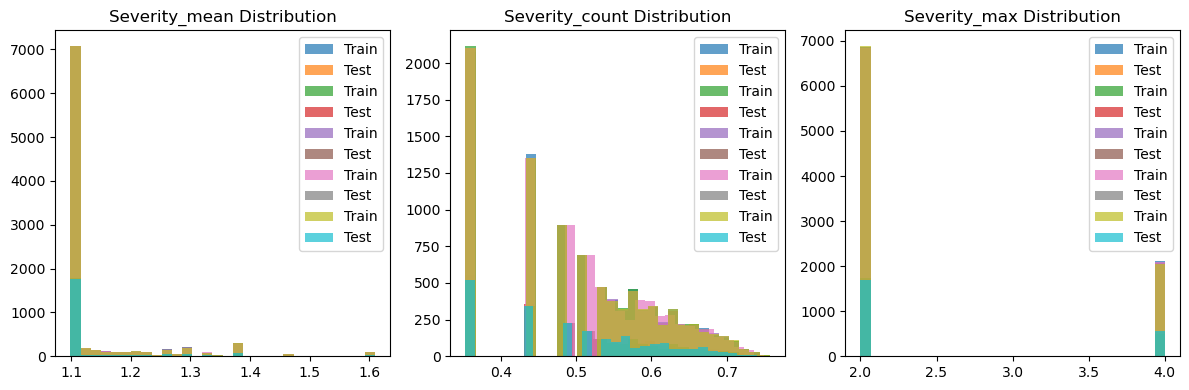

In [ ]:
def test_fold_loop(X, y):
    """
    Visualize and verify the stratified k-fold splits for multiple regression targets.

    This function applies the manual_regression_kfold_split() method to three
    target variables ('Severity_mean', 'Severity_count', and 'Severity_max'),
    prints the number of samples in each train/test split, and visualizes the
    target value distributions to confirm balanced stratification.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix used for consistency in fold creation.
    y : pd.DataFrame
        DataFrame containing target columns: 
        'Severity_mean', 'Severity_count', and 'Severity_max'.
    """

    # Generate stratified folds for each target variable
    sum_folds   = manual_regression_kfold_split(X, y['Severity_mean'],  k=5, seed=42)
    count_folds = manual_regression_kfold_split(X, y['Severity_count'], k=5, seed=42)
    max_folds   = manual_regression_kfold_split(X, y['Severity_max'],   k=5, seed=42)

    # Create a figure with three subplots (for the three targets)
    plt.figure(figsize=(12, 4))

    # === 1️⃣ Severity_mean folds ===
    for i, (train_idx, test_idx) in enumerate(sum_folds):
        # Display the number of samples in each split
        print(f"Fold {i+1}: Train instances = {len(train_idx)}, Test instances = {len(test_idx)}")

        # Plot histogram for train/test distributions (overlaid)
        plt.subplot(1, 3, 1)
        plt.hist(y['Severity_mean'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_mean'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_mean Distribution')
        plt.xlabel('Severity_mean')
        plt.ylabel('Frequency')
        plt.legend()

    # === 2️⃣ Severity_count folds ===
    for i, (train_idx, test_idx) in enumerate(count_folds):
        plt.subplot(1, 3, 2)
        plt.hist(y['Severity_count'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_count'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_count Distribution')
        plt.xlabel('Severity_count')
        plt.legend()

    # === 3️⃣ Severity_max folds ===
    for i, (train_idx, test_idx) in enumerate(max_folds):
        plt.subplot(1, 3, 3)
        plt.hist(y['Severity_max'].iloc[train_idx], bins=30, alpha=0.7, label='Train' if i == 0 else "")
        plt.hist(y['Severity_max'].iloc[test_idx], bins=30, alpha=0.7, label='Test' if i == 0 else "")
        plt.title('Severity_max Distribution')
        plt.xlabel('Severity_max')
        plt.legend()

    # Adjust subplot spacing and display the plots
    plt.tight_layout()
    plt.show()

# Run visual verification for your dataset
test_fold_loop(X, y)



In [ ]:
def nested_cv_ridge(X, y_target, outer_k=10, inner_k=3):
    """
    Perform fully manual nested cross-validation for Ridge Regression.

    Implements both the outer and inner cross-validation loops from scratch.
    The inner loop tunes the regularization strength (alpha), while the outer
    loop evaluates generalization performance using the tuned model.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y_target : pd.Series
        Continuous regression target.
    outer_k : int, default=10
        Number of folds for outer cross-validation (final evaluation).
    inner_k : int, default=3
        Number of folds for inner cross-validation (hyperparameter tuning).

    Returns
    -------
    results : np.ndarray
        Array of shape (outer_k, 3) containing [RMSE, MAE, R²] for each outer fold.
    final_best_alpha : float
        Most frequently selected alpha value across all outer folds.
    """

    # === Preprocessing: Handle missing values ===
    Xy = X.copy()
    Xy["__target__"] = y_target
    # Replace all NaNs with -1 instead of dropping samples
    Xy = Xy.fillna(-1)

    y_target = Xy["__target__"]
    X = Xy.drop(columns=["__target__"])

    print(f"After filling NaN: {X.shape[0]} samples, {X.shape[1]} features")

    # === Initialization ===
    results = []             # Stores RMSE, MAE, R² for each outer fold
    best_params_list = []    # Stores best alpha from each outer fold
    target_name = y_target.name if hasattr(y_target, 'name') else "Unnamed Target"

    # === Outer CV setup ===
    outer_folds = manual_regression_kfold_split(X, y_target, k=outer_k, seed=42, bins=10)
    print(f"\n=== Nested CV for target: {target_name} (Ridge Regression) ===")
    print(f"There are {len(outer_folds)} outer folds.")

    # === Outer CV loop ===
    for fold_idx, (outer_train_idx, outer_test_idx) in enumerate(outer_folds):
        print(f"\n--- Outer Fold {fold_idx+1} ---")

        # Split into training and test sets for this outer fold
        X_train, X_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
        y_train, y_test = y_target.iloc[outer_train_idx], y_target.iloc[outer_test_idx]

        # Initialize best results for this outer fold
        best_mae = np.inf
        best_params = None

        # === Inner CV for hyperparameter tuning ===
        inner_folds = manual_regression_kfold_split(X_train, y_train, k=inner_k, seed=fold_idx+1, bins=10)
        alphas = [0.001, 0.01, 0.1, 1, 10, 100, 200]  # Search space

        # Try each alpha value
        for alpha in alphas:
            inner_maes = []

            # Inner folds (train/validation split)
            for inner_train_idx, inner_val_idx in inner_folds:
                X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
                y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

                # Standardize features
                scaler = StandardScaler()
                X_inner_train = scaler.fit_transform(X_inner_train)
                X_inner_val = scaler.transform(X_inner_val)

                # Train Ridge regression
                model = Ridge(alpha=alpha, random_state=42)
                model.fit(X_inner_train, y_inner_train)

                # Evaluate on validation fold
                preds = model.predict(X_inner_val)
                mae = mean_absolute_error(y_inner_val, preds)
                inner_maes.append(mae)

            # Compute average validation MAE for this alpha
            mean_mae = np.mean(inner_maes)
            if mean_mae < best_mae:
                best_mae = mean_mae
                best_params = {'alpha': alpha}

        best_params_list.append(best_params)
        print(f"Best params from inner CV: {best_params} (MAE={best_mae:.3f})")

        # === Outer evaluation ===
        # Retrain on full outer training set with best alpha
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = Ridge(**best_params, random_state=42)
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

        # Evaluate metrics on outer test set
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        results.append([rmse, mae, r2])

        print(f"Fold {fold_idx+1}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")

    # === Compute overall results ===
    results = np.array(results)

    # Determine most frequently selected alpha across folds
    best_alphas = [p['alpha'] for p in best_params_list]
    unique, counts = np.unique(best_alphas, return_counts=True)
    final_best_alpha = unique[np.argmax(counts)]

    print(f"\nFinal Best Parameter for {target_name}: alpha = {final_best_alpha}")
    print(f"(Chosen {np.max(counts)} out of {len(best_alphas)} folds)")

    return results, final_best_alpha


After dropping NaN: 11167 samples, 158 features

=== Nested CV for target: __target__ (Ridge Regression) ===
There are 10 outer folds.

--- Outer Fold 1 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.076)
Fold 1: RMSE=0.094, MAE=0.078, R²=0.259

--- Outer Fold 2 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 2: RMSE=0.093, MAE=0.076, R²=0.264

--- Outer Fold 3 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 3: RMSE=0.091, MAE=0.075, R²=0.257

--- Outer Fold 4 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 4: RMSE=0.093, MAE=0.078, R²=0.260

--- Outer Fold 5 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 5: RMSE=0.094, MAE=0.078, R²=0.242

--- Outer Fold 6 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 6: RMSE=0.091, MAE=0.076, R²=0.287

--- Outer Fold 7 ---
Best params from inner CV: {'alpha': 0.001} (MAE=0.077)
Fold 7: RMSE=0.091, MAE=0.074, R²=0.296

--- Outer Fold 8 ---
Best params from 

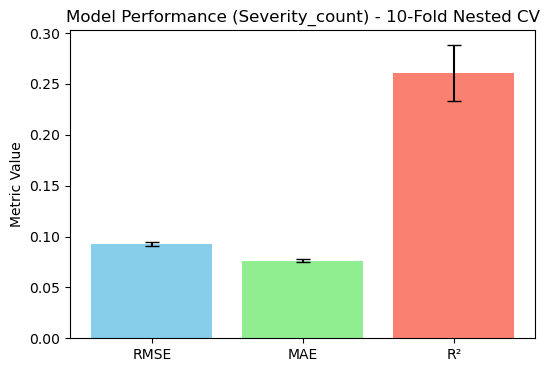


Nested Cross-Validation Results for Severity_mean
RMSE : 0.065 ± 0.004
MAE  : 0.037 ± 0.002
R²   : 0.494 ± 0.034
Final Best Alpha: 200


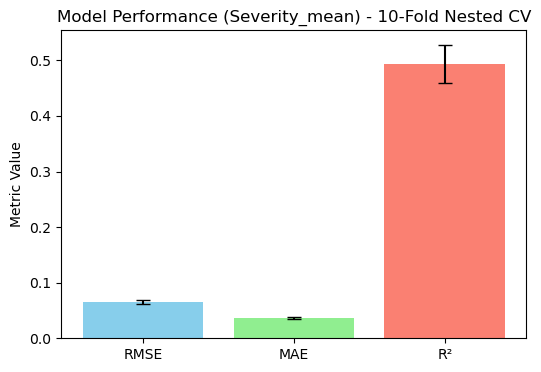


Nested Cross-Validation Results for Severity_max
RMSE : 0.668 ± 0.017
MAE  : 0.478 ± 0.013
R²   : 0.373 ± 0.031
Final Best Alpha: 0.001


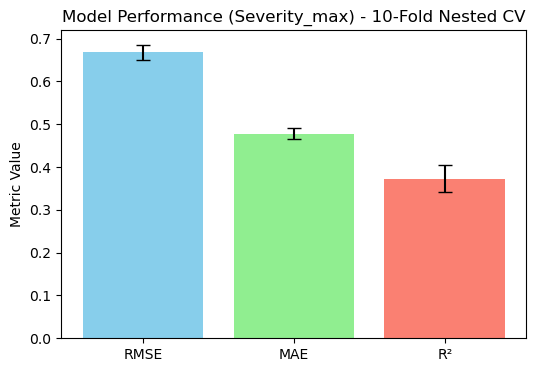

In [7]:
results_dict = {}
final_params = {}

for target in target_cols:
    result, final_alpha = nested_cv_ridge(X, y[target], outer_k=10, inner_k=3)
    results_dict[target] = result
    final_params[target] = final_alpha

for target, results in results_dict.items():
    rmse_mean, mae_mean, r2_mean = results.mean(axis=0)
    rmse_std, mae_std, r2_std = results.std(axis=0)

    print("\n==========================")
    print(f"Nested Cross-Validation Results for {target}")
    print("==========================")
    print(f"RMSE : {rmse_mean:.3f} ± {rmse_std:.3f}")
    print(f"MAE  : {mae_mean:.3f} ± {mae_std:.3f}")
    print(f"R²   : {r2_mean:.3f} ± {r2_std:.3f}")
    print(f"Final Best Alpha: {final_params[target]}")

    metrics = ['RMSE', 'MAE', 'R²']
    means = [rmse_mean, mae_mean, r2_mean]
    stds = [rmse_std, mae_std, r2_std]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics, means, yerr=stds, capsize=5,
            color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel("Metric Value")
    plt.title(f"Model Performance ({target}) - 10-Fold Nested CV")
    plt.show()

In [8]:
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def manual_learning_curve_regression(model, X, y, train_fractions=None, k=10, seed=42):
    """
    Computes a manual learning curve for regression tasks using custom K-fold splits.
    Works with any sklearn-like regressor (e.g., LinearRegression, SVR, XGBRegressor).

    Parameters:
        model: regression model (must support .fit() and .predict())
        X: DataFrame of features
        y: Series of continuous target values
        train_fractions: list of fractions of training data to use
        k: number of folds
        seed: random seed
    """

    # === Step 1. Remove NaN ===
    Xy = X.copy()
    Xy["__target__"] = y
    Xy = Xy.fillna(-1)
    y = Xy["__target__"]
    X = Xy.drop(columns=["__target__"])
    print(f"After dropping NaN: {X.shape[0]} samples, {X.shape[1]} features")

    # === Step 2. Default fractions ===
    if train_fractions is None:
        train_fractions = [0.1, 0.3, 0.5, 0.7, 1.0]

    np.random.seed(seed)
    splits = manual_regression_kfold_split(X, y, k=k, seed=seed, bins=10)

    results = []

    # === Step 3. For each training fraction ===
    for frac in train_fractions:
        fold_train_rmse, fold_val_rmse = [], []
        fold_train_mae,  fold_val_mae  = [], []
        fold_train_r2,   fold_val_r2   = [], []

        print(f"\nCurrent training fraction: {frac*100:.0f}%")

        for fold_idx, (train_idx, test_idx) in enumerate(splits):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Subsample training set
            n_samples = int(len(X_train) * frac)
            selected_idx = np.random.choice(X_train.index, size=n_samples, replace=False)
            X_train_frac = X_train.loc[selected_idx]
            y_train_frac = y_train.loc[selected_idx]
            X_train_frac, y_train_frac = shuffle(X_train_frac, y_train_frac, random_state=seed)

            # Scaling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_frac)
            X_test_scaled  = scaler.transform(X_test)

            # Train new model instance
            model_fold = model.__class__(**model.get_params())
            model_fold.fit(X_train_scaled, y_train_frac)

            # Predict
            train_preds = model_fold.predict(X_train_scaled)
            val_preds   = model_fold.predict(X_test_scaled)

            # Metrics
            train_rmse = np.sqrt(mean_squared_error(y_train_frac, train_preds))
            val_rmse   = np.sqrt(mean_squared_error(y_test, val_preds))
            train_mae  = mean_absolute_error(y_train_frac, train_preds)
            val_mae    = mean_absolute_error(y_test, val_preds)
            train_r2   = r2_score(y_train_frac, train_preds)
            val_r2     = r2_score(y_test, val_preds)

            fold_train_rmse.append(train_rmse)
            fold_val_rmse.append(val_rmse)
            fold_train_mae.append(train_mae)
            fold_val_mae.append(val_mae)
            fold_train_r2.append(train_r2)
            fold_val_r2.append(val_r2)

        # Average metrics
        result = {
            'fraction': frac,
            'train_RMSE_mean': np.mean(fold_train_rmse),
            'val_RMSE_mean':   np.mean(fold_val_rmse),
            'train_MAE_mean':  np.mean(fold_train_mae),
            'val_MAE_mean':    np.mean(fold_val_mae),
            'train_R2_mean':   np.mean(fold_train_r2),
            'val_R2_mean':     np.mean(fold_val_r2),
        }
        results.append(result)

        print(f"RMSE (train/val): {result['train_RMSE_mean']:.3f}/{result['val_RMSE_mean']:.3f} | "
              f"MAE (train/val): {result['train_MAE_mean']:.3f}/{result['val_MAE_mean']:.3f} | "
              f"R² (train/val): {result['train_R2_mean']:.3f}/{result['val_R2_mean']:.3f}")

    return pd.DataFrame(results)



Learning Curve for Severity_count
After dropping NaN: 11167 samples, 158 features

Current training fraction: 5%
RMSE (train/val): 0.076/0.429 | MAE (train/val): 0.061/0.105 | R² (train/val): 0.496/-18.567

Current training fraction: 10%
RMSE (train/val): 0.083/0.202 | MAE (train/val): 0.068/0.087 | R² (train/val): 0.392/-5.206

Current training fraction: 15%
RMSE (train/val): 0.087/0.188 | MAE (train/val): 0.071/0.087 | R² (train/val): 0.350/-4.382

Current training fraction: 20%
RMSE (train/val): 0.088/0.229 | MAE (train/val): 0.072/0.085 | R² (train/val): 0.340/-8.678

Current training fraction: 25%
RMSE (train/val): 0.088/0.118 | MAE (train/val): 0.072/0.080 | R² (train/val): 0.339/-0.233

Current training fraction: 30%
RMSE (train/val): 0.089/0.103 | MAE (train/val): 0.073/0.079 | R² (train/val): 0.325/0.083

Current training fraction: 35%
RMSE (train/val): 0.090/0.203 | MAE (train/val): 0.074/0.083 | R² (train/val): 0.308/-4.702

Current training fraction: 40%
RMSE (train/val): 

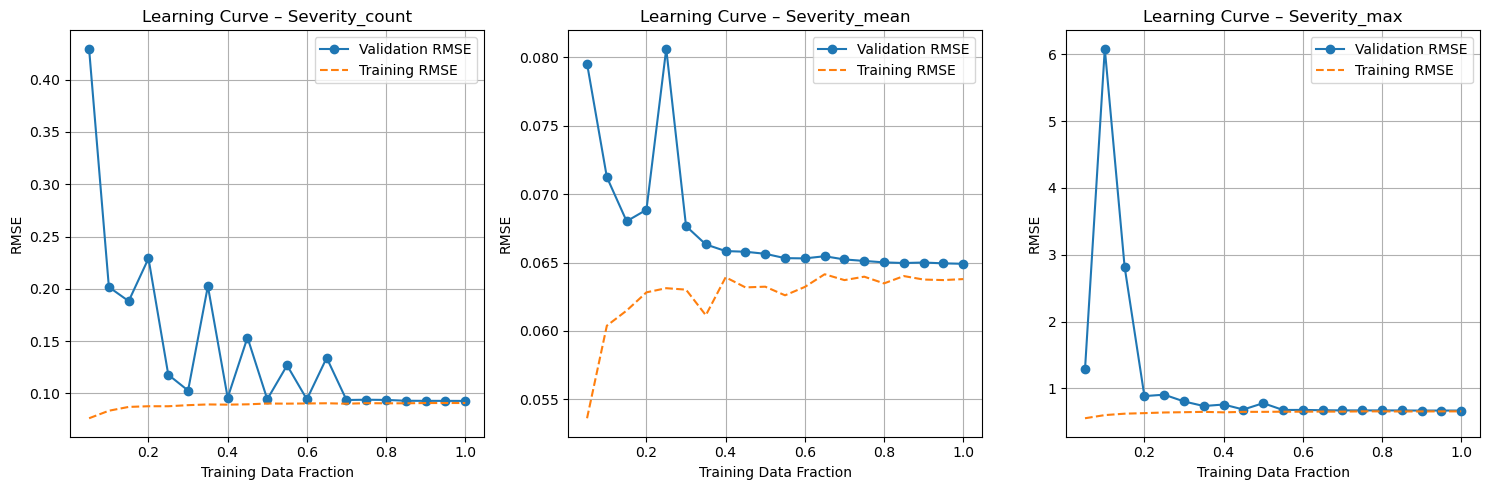

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

#  best_params  from the nest-cv 
best_params = {
    'Severity_count': {'alpha': 10},
    'Severity_mean':  {'alpha': 200},
    'Severity_max':   {'alpha': 0.001}
}

learning_curve_results = {}

for target, params in best_params.items():
    print(f"\nLearning Curve for {target}")

    # using Ridge Regression
    model = Ridge(**params, random_state=42)

    # run the learning curve with same model
    lc_result = manual_learning_curve_regression(
        model,
        X,
        y[target],
        train_fractions=np.linspace(0.05, 1.0, 20),
        k=5
    )
    learning_curve_results[target] = lc_result
    
plt.figure(figsize=(15, 5))
for i, (target, df) in enumerate(learning_curve_results.items()):
    plt.subplot(1, 3, i + 1)
    plt.plot(df['fraction'], df['val_RMSE_mean'], 'o-', label='Validation RMSE')
    plt.plot(df['fraction'], df['train_RMSE_mean'], '--', label='Training RMSE')
    plt.xlabel("Training Data Fraction")
    plt.ylabel("RMSE")
    plt.title(f"Learning Curve – {target}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

--- SHAP for Severity_count ---


C:\Users\rosas\AppData\Local\Temp\ipykernel_15224\3619099876.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


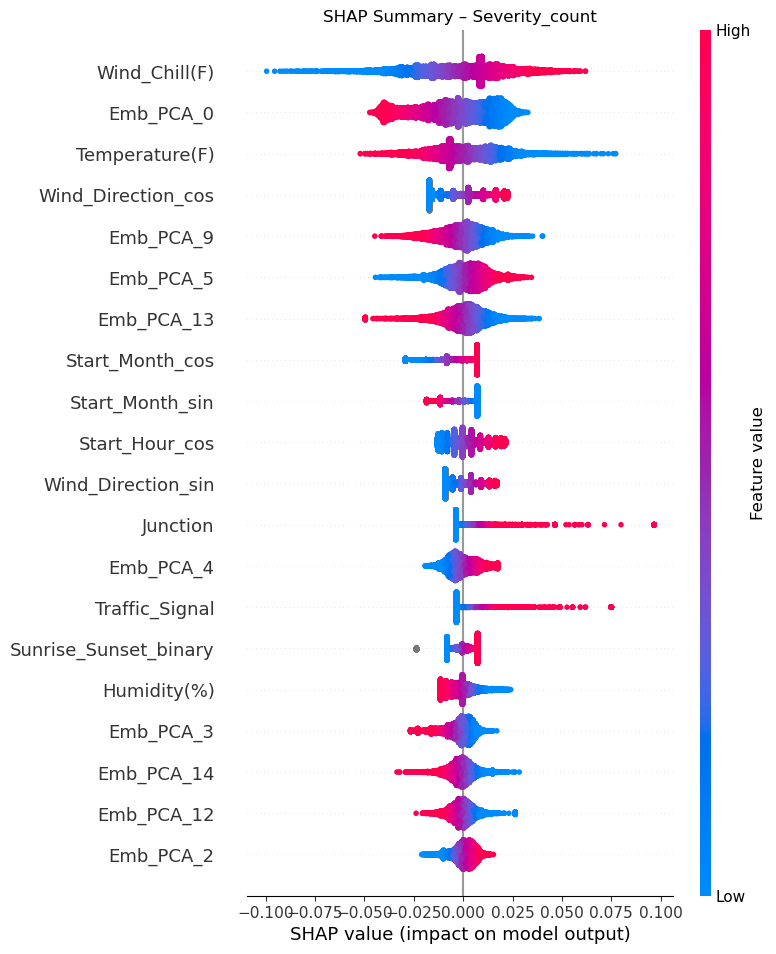

--- SHAP for Severity_mean ---


C:\Users\rosas\AppData\Local\Temp\ipykernel_15224\3619099876.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


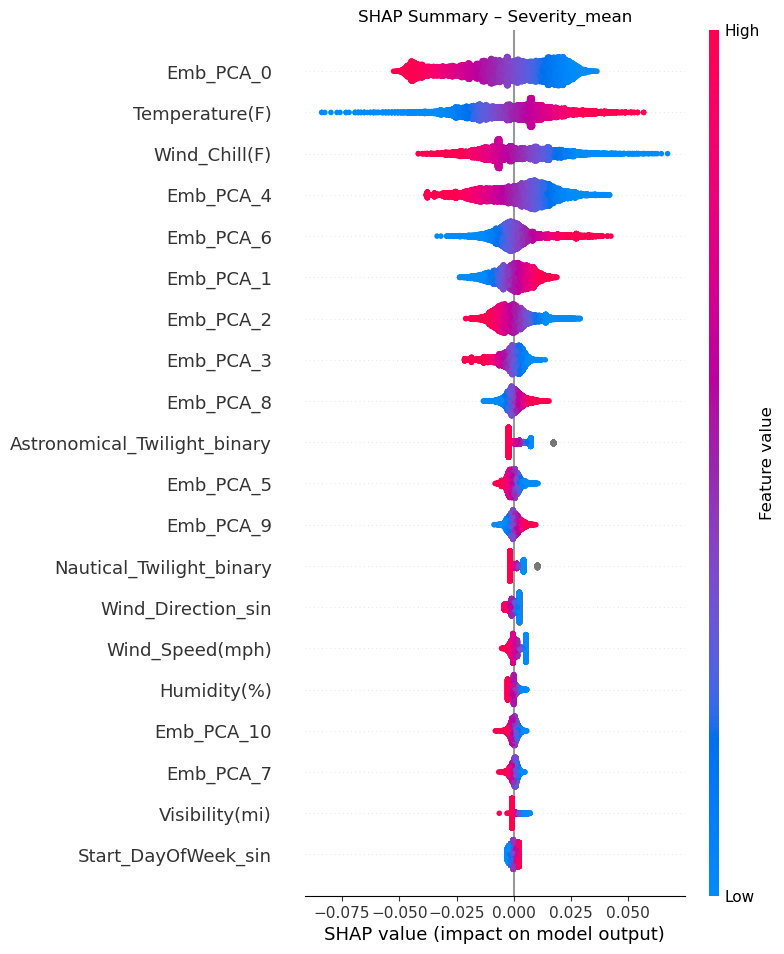

--- SHAP for Severity_max ---


C:\Users\rosas\AppData\Local\Temp\ipykernel_15224\3619099876.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X, show=False)


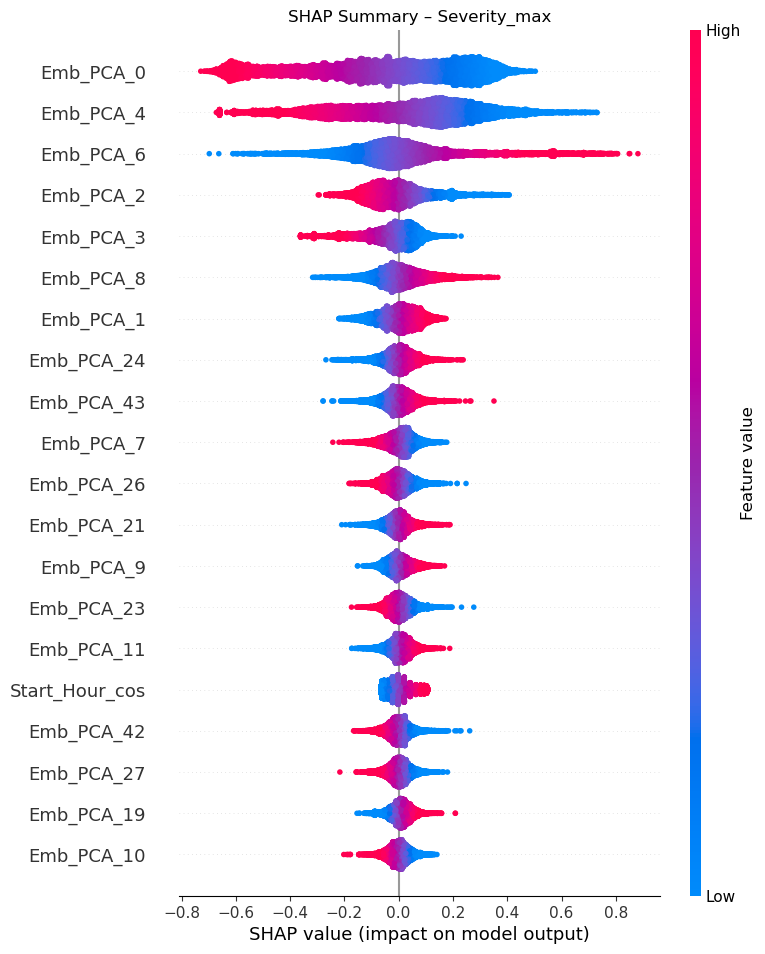

In [12]:
for target, params in best_params.items():
    print(f"--- SHAP for {target} ---")

    # === Drop NaN ===
    Xy = X.copy()
    Xy["__target__"] = y[target]
    Xy = Xy.fillna(-1)
    X_clean = Xy.drop(columns=["__target__"])
    y_clean = Xy["__target__"]

    # === Ridge model ===
    model = Ridge(**params, random_state=42)
    model.fit(X_clean, y_clean)

    # === SHAP ===
    explainer = shap.Explainer(model, X_clean)
    shap_values = explainer(X_clean)

    shap.summary_plot(shap_values, X, show=False)
    plt.title(f"SHAP Summary – {target}")
    plt.show()

